In [1]:
import numpy as np
from scipy.integrate import odeint

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation

%matplotlib inline

In [2]:
class flow(object):
    def __init__(self, nx=256, ny=256, lx=1.0e6, ly=2.0e6, beta=6.0e-10, kappa=10.0, w=4.0e-6):
        x = np.linspace(-np.pi, np.pi, nx, endpoint=False)
        y = np.linspace(-np.pi, np.pi, ny, endpoint=False)
        self.xx, self.yy = np.meshgrid(x,y)
        
        kx = np.fft.rfftfreq(nx, lx/nx)
        ky = np.fft.fftfreq(ny, ly/ny)
        self.kkx, self.kky = np.meshgrid(kx,ky)
        
        self.ksq = self.kkx**2 + self.kky**2
        self.ksq[0,0] += 1.0e-15
        self.kmax = np.min(np.max(kx), np.max(ky))
        
        self.nx = nx
        self.ny = ny
        self.lx = lx
        self.ly = ly
        self.beta = beta
        self.kappa = kappa
        self.w = w
        
        self.psihat = np.zeros((nx,int(ny/2+1)), dtype=complex)
        fzero = 1.0e-4
        thick = 1.0e3
        famp = self.w * fzero/thick
        phases = np.random.uniform(-np.pi, np.pi, size=self.psihat.shape)
        
        forcing = np.zeros_like(self.psihat, dtype=complex)
        forcing[np.abs(self.ksq - self.kmax**2/81) < 3e-11] = famp
        self.forcefield = forcing * (np.cos(phases) + np.sin(phases)*(0.0+1.0j))
        self.psihat += self.forcefield

        self.psi = np.fft.irfft2(self.psihat)
        
        self.qhat = -self.psihat*self.ksq
        self.q = np.fft.irfft2(self.qhat)
        
    def plot_psi(self):
        return plt.contour(self.xx, self.yy, self.psi)
        
    def plot_q(self):
        return plt.contour(self.xx, self.yy, self.q)
        
        
    def get_psihat_from_qhat(self, qhat):
        """What it says on the tin.        
        """
        
        psihat = qhat/self.ksq
        return psihat
        
    def waveterm(self, psihat):
        """Compute the beta wave term.
        
        Assume that we start and end in Fourier space.
        """
        return self.beta*psihat*self.kkx*(0.0+1.0j)
    
    def dissipation(self, qhat):
        """Dissipation term, all in Fourier space."""
        
        return self.kappa*qhat*self.ksq
    
    def forcing(self, t):
        """Forcing is in the form of random phases in a k-space anulus.
        
        The magnitude (and variables) come from the ocean problem, and probably aren't appropriate for
        atmospheric simulation.
        """
#        fzero = 1.0e-4
#        thick = 1.0e3
#        famp = self.w * fzero/thick

#        phases = np.random.uniform(-np.pi, np.pi, size=self.qhat.shape)        
#        return self.forcefield * (np.cos(phases) + np.sin(phases)*(0.0+1.0j))
        return self.forcefield

    def nlterm(self, qhat, psihat):
        """Compute the jacobian determinant."""
        
        # dealias
        qhat[self.ksq>2/3*self.kmax] = 0.0
        psihat[self.ksq>2/3*self.kmax] = 0.0
        
        psihat_x = psihat*self.kkx*(0.0+1.0j)
        psihat_y = psihat*self.kky*(0.0+1.0j)
        qhat_x = qhat*self.kkx*(0.0+1.0j)
        qhat_y = qhat*self.kky*(0.0+1.0j)
        
        psi_x = np.fft.irfft2(psihat_x)
        psi_y = np.fft.irfft2(psihat_y)
        q_x = np.fft.irfft2(qhat_x)
        q_y = np.fft.irfft2(qhat_y)
        
        jac = psi_x*q_y - psi_y*q_x
        
        jachat = np.fft.rfft2(jac)
        return jachat
    
    def rhs(self, q_reshaped, t):
        """The time derivative, ready for the integrator."""
        
        qhat = self.unmunge(q_reshaped)
        
        psihat = self.get_psihat_from_qhat(qhat)
        nlterm = self.nlterm(qhat, psihat)
        waveterm = self.waveterm(psihat)
        dissipation = self.dissipation(qhat)
        forcing = self.forcing(t)
        
        return self.munge(forcing - dissipation + waveterm + nlterm)
    
    def munge(self, qhat):
        """format a complex k-space field for odeint"""
        
        r = qhat.real
        i = qhat.imag
        z = np.array([r,i])
        return z.reshape(-1)
    
    def unmunge(self, munged):
        """Return the 1d real sequence to its 2d complex state"""
        
        z = munged.reshape((2,self.nx,int(self.ny/2+1)))
        r = z[0]
        i = z[1]
        return r + (0+1.0j)*i

In [3]:
foo = flow()
t = np.linspace(0, 3600*65.6, 120)

result = odeint(foo.rhs, foo.munge(foo.qhat), t)

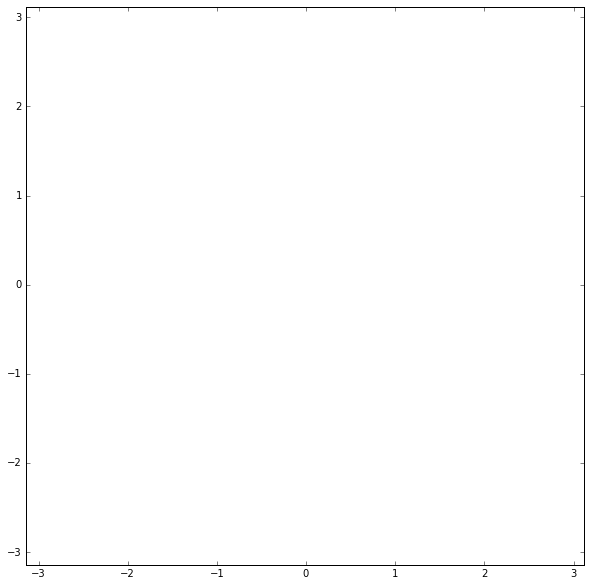

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes()  
plt.xlabel(r'x')
plt.ylabel(r'y')

totalmax = np.max([np.max(np.abs(np.fft.irfft2(foo.unmunge(frame)))) for frame in result])
levels = np.linspace(-totalmax, totalmax, 10)

# animation function
def animate(i): 
    z = np.fft.irfft2(foo.unmunge(result[i]))
    ax.clear()
    
    cont = plt.contour(foo.xx, foo.yy, z, levels)
    return cont  

anim = animation.FuncAnimation(fig, animate, frames=len(t), blit=False)
mywriter = animation.FFMpegWriter()

anim.save("animation.mp4", writer=mywriter, fps=45, dpi=100, bitrate=4000)

/Users/cmckay/anaconda/envs/layercode/lib/python3.5/site-packages/numpy/ma/core.py:2724: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy, subok=True, ndmin=ndmin)


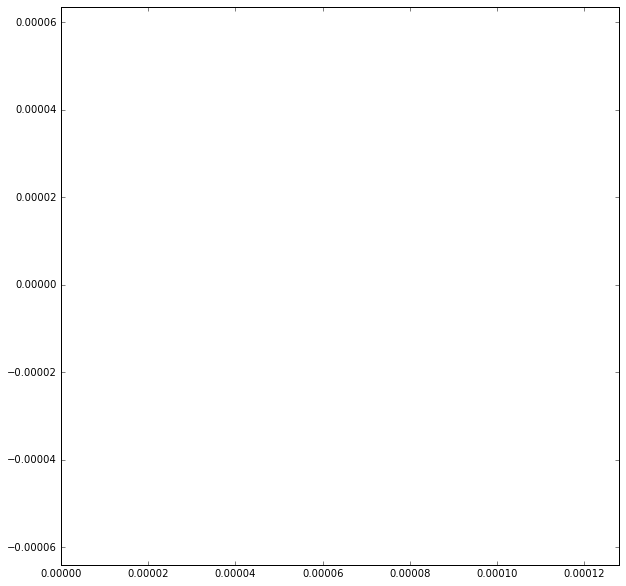

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes()  
plt.xlabel(r'x')
plt.ylabel(r'y')

totalmax = np.max([np.max(np.abs(foo.unmunge(frame))) for frame in result])
levels = np.linspace(-totalmax, totalmax, 10)

# animation function
def animate(i): 
    z = foo.unmunge(result[i])
    ax.clear()
    
    cont = plt.contour(foo.kkx, foo.kky, z, levels)
    return cont  

anim = animation.FuncAnimation(fig, animate, frames=len(t), blit=False)
mywriter = animation.FFMpegWriter()

anim.save("kspace.mp4", writer=mywriter, fps=45, dpi=100, bitrate=4000)